In [1]:
import dingo
import os
import cobra
import pickle

In [2]:
main_path = '/'.join(os.getcwd().split("/")[:-1])

In [3]:
cobra_config = cobra.Configuration()
cobra_config.solver = 'glpk'

In [4]:
simplified_tranf_polytope_file = pickle.load(open((main_path + "/ext_data/polytope_iAB_AMO1410_SARS-CoV-2.xml.pckl"), "rb"))
simplified_tranf_polytope = simplified_tranf_polytope_file[0]

In [5]:
A = simplified_tranf_polytope.A.to_numpy()
b = simplified_tranf_polytope.b.to_numpy()

In [6]:
P = dingo.HPolytope(A, b)

In [27]:
A, b, Tr, Tr_shift, samples = P.slow_mmcs(ess=1000)

phase 1: number of correlated samples = 13300, effective sample size = 101, ratio of the maximum singilar value over the minimum singular value = 17377.2
phase 2: number of correlated samples = 13300, effective sample size = 98, ratio of the maximum singilar value over the minimum singular value = 3087.14
phase 3: number of correlated samples = 4100, effective sample size = 1374


 [1]maximum marginal PSRF: 2.63153
[2]maximum marginal PSRF: 1.3478
[2]total ess: 1472
[2]maximum marginal PSRF: 1.00558
[2]total ess: 1374


In [ ]:
with open("sars_model_samples.pckl", "wb") as dingo_steadystates_file: 
         pickle.dump(samples, dingo_steadystates_file)

In [10]:
samples = pickle.load(open("sars_model_samples.pckl", 'rb'))

In [11]:
samples.shape

(665, 4100)

* Run FBA 
* Compute mean for each reaction 
* Compare with corresponding flux from FBA
* Plot those that have more than 1 order of magnitude difference

In [12]:
sars_model = dingo.MetabolicNetwork.from_sbml(main_path + "/ext_data/iAB_AMO1410_SARS-CoV-2.xml")

In [13]:
sars_model.set_slow_mode()

In [14]:
len(sars_model.reactions)

3394

In [15]:
mapped_samples = simplified_tranf_polytope.back_transform(samples)

In [16]:
mapped_samples.shape

(3394, 4100)

In [17]:
reactions_mean_flux_values = mapped_samples.mean(axis=1)

In [24]:
reactions_mean_flux_values.shape

(3394,)

In [19]:
reactions_mean_flux_values

array([-3.53079955e-12, -5.82594705e-13, -1.11750787e-12, ...,
       -4.80362661e-05,  9.09729766e-05,  1.35698579e-04])

In [26]:
# fba_values is a tuple with a single array
fba_values = sars_model.fba()[0]

In [27]:
fba_values.shape

(3394,)

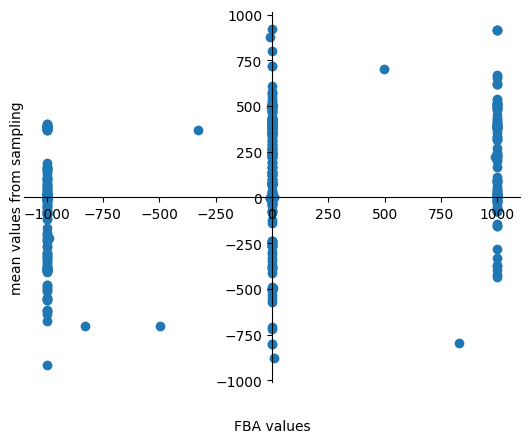

In [51]:
import matplotlib.pylab as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('FBA values')
plt.ylabel('mean values from sampling')
ax.xaxis.set_label_coords(0.5, -.1)
ax.yaxis.set_label_coords(0, 0.5)
plt.scatter(x = fba_values, y = reactions_mean_flux_values)

In [53]:
sars_model.biomass_index

3393

In [54]:
fba_values[3393]

0.014424251377314738

In [55]:
sars_model.fba()

(array([-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        ,  0.01442425]),
 0.014424251377314738)

/tmp/ipykernel_8028/712178922.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(reactions_mean_flux_values,bins=10)


<AxesSubplot: ylabel='Density'>

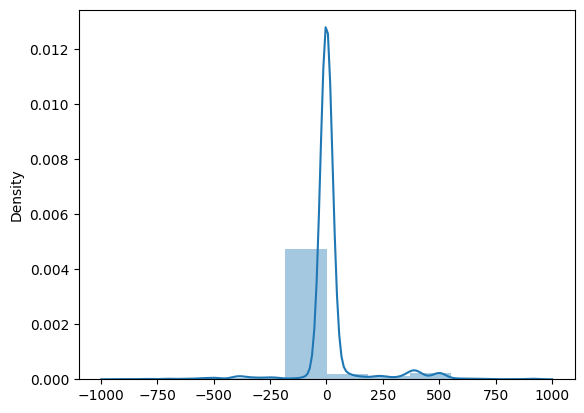

In [31]:
import seaborn as sn
sn.distplot(reactions_mean_flux_values, bins=10)

/tmp/ipykernel_8028/2652005083.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(fba_values, bins=10)


<AxesSubplot: ylabel='Density'>

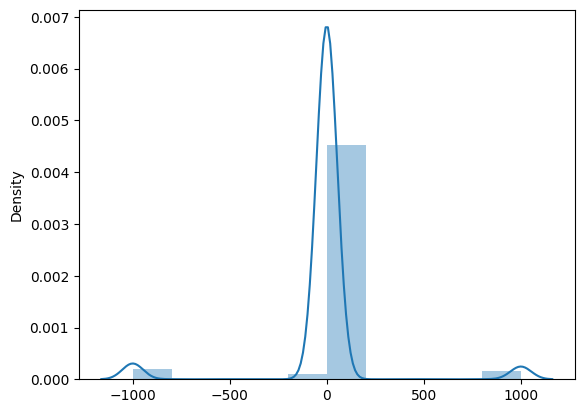

In [35]:
sn.distplot(fba_values, bins=10)